In [1]:
import os
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
# Function to get image paths and labels
def get_image_paths_and_labels(data_path):
    """Gathering image paths and labels with proper label encoding."""
    image_paths = []
    labels = []
    categories = sorted(os.listdir(data_path))  # Ensure consistent ordering
    
    for category in categories:
        category_path = os.path.join(data_path, category)
        if os.path.isdir(category_path):
            images = os.listdir(category_path)
            if not images:
                print(f"Warning: No images found in {category_path}")
                continue  # Skip empty folders
            for img_name in images:
                img_path = os.path.join(category_path, img_name)
                image_paths.append(img_path)
                labels.append(category)
    
    print(f"Found {len(image_paths)} images across {len(categories)} categories.")
    
    # Convert labels to numerical values
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)  # Encodes labels into numbers
    return image_paths, labels, categories, label_encoder

In [3]:
# Custom Dataset Class
class CustomImageDataset(Dataset):
    """
    A custom dataset class for loading images and their corresponding labels.
    
    Args:
        image_paths (list): List of file paths to the images.
        labels (list): List of labels corresponding to the images.
        transform (callable, optional): Optional transform to be applied on a sample.
    """
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths  # List of image file paths
        self.labels = labels  # Corresponding labels
        self.transform = transform  # Optional image transformations

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Retrieves an image and its corresponding label at the specified index.
        Args:
            idx (int): Index of the sample to retrieve.
        Returns:
            tuple: (image, label) where image is a transformed image tensor and label is a tensor.
        """
        img_path = self.image_paths[idx] # Get image path
        
        try:
            # Load the image and convert it to RGB format
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image: {img_path}, Error: {e}")
            return None  # Graceful handling of image loading errors
        
        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        # Convert label to a tensor (ensure it's in the correct format for training)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

In [4]:
class ResNet(nn.Module):
    """
    Implementation of ResNet architecture with bottleneck residual blocks.
    
    Args:
        block (nn.Module): Residual block type (Bottleneck block for ResNet-50, 101, 152).
        layers (list): Number of residual blocks in each ResNet layer.
        image_channels (int): Number of input image channels (e.g., 3 for RGB images).
        num_classes (int): Number of output classes for classification.
    """
    def __init__(self, block, layers, image_channels, num_classes, dropout_rate=0.5):
        super(ResNet, self).__init__()
        self.in_channels = 64

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet layers
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Adaptive pooling and fully connected layer for classification
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout2d(dropout_rate)
        self.fc = nn.Linear(512 * 4, num_classes)  # 4x expansion in bottleneck block

    def _make_layer(self, block, out_channels, num_residual_blocks, stride):
        """
        Constructs a ResNet layer with the given number of residual blocks.
        """
        identity_downsample = None
        layers = []

        # Apply downsampling when stride is not 1 or in_channels do not match
        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * 4)
            )

        # First residual block with identity downsampling
        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels * 4  # Update input channels for next blocks

        # Remaining residual blocks without downsampling
        for _ in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass of the ResNet model.
        """
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)   # Flatten to (batch_size, features)
        x = self.dropout(x)
        x = self.fc(x)
        return x

class Block(nn.Module):
    """
    Bottleneck residual block for ResNet-50, ResNet-101, and ResNet-152.
    
    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels before expansion.
        identity_downsample (nn.Module, optional): Downsampling layer for identity mapping.
        stride (int): Stride for the 3x3 convolution.
    """
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.expansion = 4

        # First 1x1 convolution (reduces channel dimensions)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second 3x3 convolution (feature extraction)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Third 1x1 convolution (expands channel dimensions back)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.identity_downsample = identity_downsample  # Used if identity mapping needs adjustment

    def forward(self, x):
        """
        Forward pass of the bottleneck residual block.
        """
        identity = x  # Store input for identity shortcut

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        # Apply identity mapping with downsampling if needed
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        out += identity  # Add skip connection
        out = self.relu(out)
        return out
    
def ResNet50(img_channels=3, num_classes=21):
    """Creates a ResNet-50 model."""
    return ResNet(Block, [3, 4, 6, 3], img_channels, num_classes)

def ResNet101(img_channels=3, num_classes=21):
    """Creates a ResNet-101 model."""
    return ResNet(Block, [3, 4, 23, 3], img_channels, num_classes)

def ResNet152(img_channels=3, num_classes=21):
    """Creates a ResNet-152 model."""
    return ResNet(Block, [3, 8, 36, 3], img_channels, num_classes)

In [5]:
# Training and testing functions

def train_model(model, train_loader, criterion, optimizer, device, epochs=10):
    """
    Trains the ResNet-50 model.

    Args:
    - model (nn.Module): The ResNet-50 model.
    - train_loader (DataLoader): Training dataset loader.
    - criterion (loss function): Loss function (e.g., CrossEntropyLoss).
    - optimizer (torch.optim): Optimizer (e.g., Adam, SGD).
    - device (torch.device): Device (CPU/GPU).
    - epochs (int): Number of training epochs.
    """
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")

def evaluate_model(model, test_loader, criterion, device, class_names):
    """
    Evaluates the ResNet-50 model on the test dataset and prints the classification report and confusion matrix.

    Args:
    - model (nn.Module): The ResNet-50 model.
    - test_loader (DataLoader): Test dataset loader.
    - criterion (loss function): Loss function (e.g., CrossEntropyLoss).
    - device (torch.device): Device (CPU/GPU).
    - class_names (list): List of class names for labels.
    """
    model.eval()
    test_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    print(f"Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")

    # Print Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


Step1: Getting the image paths and labels...
Found 2100 images across 21 categories.
Step2: Splitting the images and labels into training and test datasets...
Step3: Initiating custom dataset class for both traing and testing dataset...
Step4: Initiating dataloader for both traing and testing dataset...
Step5: The ResNet-50 model is being initiated...
Step6: Defining loss function and optimizer...
Step7: The model traing started...


c:\Users\debli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch [1/17], Loss: 2.9185, Accuracy: 15.10%
Epoch [2/17], Loss: 2.2298, Accuracy: 29.80%
Epoch [3/17], Loss: 1.8534, Accuracy: 40.48%
Epoch [4/17], Loss: 1.5534, Accuracy: 49.12%
Epoch [5/17], Loss: 1.3117, Accuracy: 56.60%
Epoch [6/17], Loss: 1.0207, Accuracy: 64.56%
Epoch [7/17], Loss: 0.9313, Accuracy: 68.57%
Epoch [8/17], Loss: 0.8127, Accuracy: 71.77%
Epoch [9/17], Loss: 0.7480, Accuracy: 75.58%
Epoch [10/17], Loss: 0.6370, Accuracy: 78.57%
Epoch [11/17], Loss: 0.5316, Accuracy: 83.67%
Epoch [12/17], Loss: 0.3499, Accuracy: 88.71%
Epoch [13/17], Loss: 0.3074, Accuracy: 90.20%
Epoch [14/17], Loss: 0.2274, Accuracy: 93.40%
Epoch [15/17], Loss: 0.2388, Accuracy: 91.84%
Epoch [16/17], Loss: 0.2655, Accuracy: 91.29%
Epoch [17/17], Loss: 0.2321, Accuracy: 93.33%
Step8: Model is being evaluated on the test dataset...
Test Loss: 2.4884, Accuracy: 57.62%

Classification Report:
                   precision    recall  f1-score   support

     agricultural       0.75      0.86      0.80    

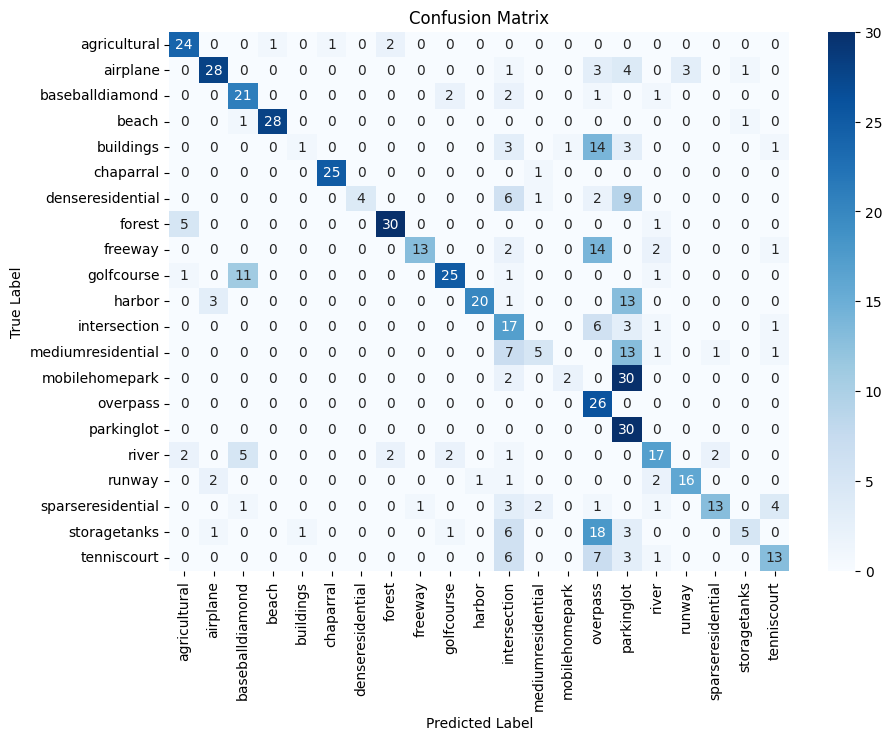

In [6]:
# Main execution

if __name__ == "__main__":
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define transformations
    transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet-50 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
    data_path = r"C:\Users\debli\Downloads\UCMerced_LandUse\UCMerced_LandUse\Images"

    # Get image paths and labels
    print("Step1: Getting the image paths and labels...")
    image_paths, labels, categories, label_encoder = get_image_paths_and_labels(data_path)

    # Split data into training and test sets (70% train, 30% test)
    print("Step2: Splitting the images and labels into training and test datasets...")
    features_train, features_test, labels_train, labels_test = train_test_split(image_paths, labels, test_size=0.3, random_state=101)

    # Load dataset
    print("Step3: Initiating custom dataset class for both traing and testing dataset...")
    train_dataset = CustomImageDataset(features_train, labels_train, transform=transform)
    test_dataset = CustomImageDataset(features_test, labels_test, transform=transform)
    
    print("Step4: Initiating dataloader for both traing and testing dataset...")
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Initialize model
    print("Step5: The ResNet-50 model is being initiated...")
    model = ResNet50(num_classes=21).to(device)

    # Define loss function & optimizer
    print("Step6: Defining loss function and optimizer...")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Train and evaluate model
    print("Step7: The model traing started...")
    train_model(model, train_loader, criterion, optimizer, device, epochs=17)
    print("Step8: Model is being evaluated on the test dataset...")
    evaluate_model(model, test_loader, criterion, device, categories)
